In [73]:
pip install equinox optax diffrax jitcdde

# Train RNN

This is an introductory example. We demonstrate what using Equinox normally looks like day-to-day.

Here, we'll train an RNN to classify clockwise vs anticlockwise spirals.

This example is available as a Jupyter notebook [here](https://github.com/patrick-kidger/equinox/blob/main/examples/train_rnn.ipynb).

In [74]:
import math
import time
import diffrax
import equinox as eqx
import jax
import jax.lax as lax
import jax.numpy as jnp
import jax.nn as jnn
import jax.random as jrandom
import numpy as np
import optax  # https://github.com/deepmind/optax
import symengine
from jitcdde import jitcdde, y, t
import numpy as np
import matplotlib.pyplot as plt

We begin by importing the usual libraries, setting up a very simple dataloader, and generating a toy dataset of spirals.

In [75]:
def dataloader(arrays, batch_size, *, key):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    while True:
        perm = jrandom.permutation(key, indices)
        (key,) = jrandom.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size

In [76]:
def get_data(num_initial_points):
    r=2.5
    K=2.
    n=0.8
    omega=0.5
    miu=0.4
    nu=1.5

    d = symengine.symbols("d")
    equations = [
        r * y(0, t) * (1 - (y(0, t) / K)) - n * y(1, t) * y(0, t),
        omega + miu * y(0, t - d) * y(1, t) - nu * y(1, t)
    ]
    ddesys = jitcdde(equations, control_pars=[d], max_delay=10.)

    ts = np.linspace(0, 30, 1000)

    # Generar puntos iniciales aleatorios
    np.random.seed(67)
    initial_points = np.random.uniform(0, 2, size=(num_initial_points, 2))

    ys = []
    for initial_point in initial_points:
        ddesys.constant_past(initial_point)
        params = [5.]
        ddesys.set_parameters(*params)
        y_values = []
        for t_val in ts:
            y_values.append(ddesys.integrate(t_val))
        ys.append(y_values)

    ys = np.array(ys)
    ts = jax.device_put(ts)
    ys = jax.device_put(ys)
    return ys, ts

In [77]:
def new_get_data(num_initial_points):
    r=2.5
    K=2.
    n=0.8
    omega=0.5
    miu=0.4
    nu=1.5


    d = symengine.symbols("d")
    equations = [
        r * y(0, t) * (1 - (y(0, t) / K)) - n * y(1, t) * y(0, t),
        omega + miu * y(0, t - d) * y(1, t) - nu * y(1, t)
    ]
    ddesys = jitcdde(equations, control_pars=[d], max_delay=10.)

    ts = np.linspace(0, 30, 1000)

    # Generar puntos iniciales aleatorios
    np.random.seed(83)
    initial_points = np.random.uniform(0, 2, size=(num_initial_points, 2))

    ys = []
    for initial_point in initial_points:
        ddesys.constant_past(initial_point)
        params = [5.]
        ddesys.set_parameters(*params)
        y_values = []
        for t_val in ts:
            y_values.append(ddesys.integrate(t_val))
        ys.append(y_values)

    ys = np.array(ys)
    ts = jax.device_put(ts)
    ys = jax.device_put(ys)
    return ys, ts

Now for our model.

Purely by way of example, we handle the final adding on of bias ourselves, rather than letting the `linear` layer do it. This is just so we can demonstrate how to use custom parameters in models.

In [78]:
class RNN(eqx.Module):
    hidden_size: int
    cell: eqx.Module
    linear: eqx.nn.Linear
    bias: jax.Array
    sequence_length: int

    def __init__(self, in_size, out_size, hidden_size, *, key, sequence_length=1000):
        ckey, lkey = jrandom.split(key)
        self.hidden_size = hidden_size
        self.cell = eqx.nn.GRUCell(in_size, hidden_size, key=ckey)
        self.linear = eqx.nn.Linear(hidden_size, out_size, use_bias=False, key=lkey)
        self.bias = jnp.zeros(out_size)
        self.sequence_length = sequence_length

    def __call__(self, input):
        hidden = jnp.zeros((self.hidden_size,))

        def f(carry, _):
            hidden, input = carry
            hidden = self.cell(input, hidden)
            output = self.linear(hidden) + self.bias
            return (hidden, output), output # carry, thing-to-stack

        init_state = (hidden, input)
        (_, _), outs = lax.scan(f, init_state, None, length=self.sequence_length)
        return jnp.stack(outs)

And finally the training loop.

In [79]:
import matplotlib.pyplot as plt
def main(
    dataset_size=500,
    batch_size=32,
    learning_rate=3e-3,
    steps=1000,
    hidden_size=16,
    depth=1,
    seed=5678,
    print_every=100,
    plot= True,
):
    loader_key, model_key = jrandom.split(jrandom.PRNGKey(seed), 2)
    xs, ys = get_data(dataset_size)
    iter_data = dataloader((xs,), batch_size, key = loader_key)

    model = RNN(in_size=2, out_size=2, hidden_size=hidden_size, key=model_key)

    @eqx.filter_value_and_grad
    def compute_loss(model, x, y):
        pred_y = jax.vmap(model)(x[:,0,:])
        return jnp.mean((x - pred_y) ** 2)

    # Important for efficiency whenever you use JAX: wrap everything into a single JIT
    # region.
    @eqx.filter_jit
    def make_step(model, x, y, opt_state):
        loss, grads = compute_loss(model, x, y)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    optim = optax.adam(learning_rate)
    opt_state = optim.init(model)
    for step, (x,) in zip(range(steps), iter_data):
        start = time.time()
        loss, model, opt_state = make_step(model, x, ys, opt_state)
        loss = loss.item()
        end = time.time()
        if (step % print_every) == 0 or step == steps - 1:
            print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")

    if plot:

      index = 1

      ys_prueba, ts_prueba = new_get_data(dataset_size)

      model_y = model( ys_prueba[index, 0])

      fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,6))
      fig.tight_layout(rect=[0, 0, 1, 0.95], pad=3.0)  # Ajustar diseño de la figura


      # Subgráfico 1
      ax1.plot(ts_prueba, ys_prueba[index, :, 0], c="dodgerblue", label="Real")
      ax1.plot(ts_prueba, model_y[:, 0], c="dodgerblue", label="Model", linestyle="dashed")
      ax1.set_xlabel('t')
      ax1.set_ylabel('T')
      ax1.legend()  # Añadir leyenda al subgráfico 1
      ax1.grid(True)  # Añadir rejilla al subgráfico 1

      # Subgráfico 2
      ax2.plot(ts_prueba, ys_prueba[index, :, 1], c="crimson", label="Real")
      ax2.plot(ts_prueba, model_y[:, 1], c="crimson", label="Model", linestyle="dashed")
      ax2.set_xlabel('t')
      ax2.set_ylabel('E')
      ax2.legend()  # Añadir leyenda al subgráfico 2
      ax2.grid(True)  # Añadir rejilla al subgráfico 2

      # Subgráfico 3
      ax3.plot(ys_prueba[index, :, 0], ys_prueba[index, :, 1], c="blue", label="Real")
      ax3.plot(model_y[:, 0], model_y[:, 1], c="red", label="Model", linestyle="dashed")
      ax3.set_xlabel('T')
      ax3.set_ylabel('E')
      ax3.legend()  # Añadir leyenda al subgráfico 3
      ax3.grid(True)  # Añadir rejilla al subgráfico 3

      # Mostrar la figura
      plt.show()

      errorT=((model_y[:, 0]-ys_prueba[0, :, 0])**2).mean()
      errorE=((model_y[:, 1]-ys_prueba[0, :, 1])**2).mean()
    return xs, ys, model

`eqx.filter_value_and_grad` will calculate the gradient with respect to all floating-point arrays in the first argument (`model`). In this case the `model` parameters will be differentiated, whilst `model.hidden_size` is an integer and will get `None` as its gradient.

Likewise, `eqx.filter_jit` will look at all the arguments passed to `make_step`, and automatically JIT-trace every array and JIT-static everything else. In this case the `model` parameters and the data `x` and `y` will be traced, whilst `model.hidden_size` is an integer and will be static'd instead.

Generating, compiling, and loading C code.
Using default integration parameters.


/usr/local/lib/python3.10/dist-packages/jitcdde/_jitcdde.py:795: UserWarning: You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.
  warn("You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.")
/usr/local/lib/python3.10/dist-packages/jitcdde/_jitcdde.py:792: UserWarning: The target time is smaller than the current time. 

Step: 0, Loss: 1.478933572769165, Computation time: 3.196059226989746
Step: 100, Loss: 0.014311619102954865, Computation time: 0.26236677169799805
Step: 200, Loss: 0.007034915965050459, Computation time: 0.04443621635437012
Step: 300, Loss: 0.009126582182943821, Computation time: 0.07339358329772949
Step: 400, Loss: 0.008892448619008064, Computation time: 0.04438138008117676
Step: 500, Loss: 0.006084142718464136, Computation time: 0.04362988471984863
Step: 600, Loss: 0.005904322490096092, Computation time: 0.04321765899658203
Step: 700, Loss: 0.005119810812175274, Computation time: 0.04521632194519043
Step: 800, Loss: 0.007021140307188034, Computation time: 0.07753896713256836
Step: 900, Loss: 0.0031145636457949877, Computation time: 0.04362320899963379
Step: 999, Loss: 0.0038967968430370092, Computation time: 0.044559478759765625
Generating, compiling, and loading C code.
Using default integration parameters.


/usr/local/lib/python3.10/dist-packages/jitcdde/_jitcdde.py:795: UserWarning: You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.
  warn("You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.")
/usr/local/lib/python3.10/dist-packages/jitcdde/_jitcdde.py:792: UserWarning: The target time is smaller than the current time. 

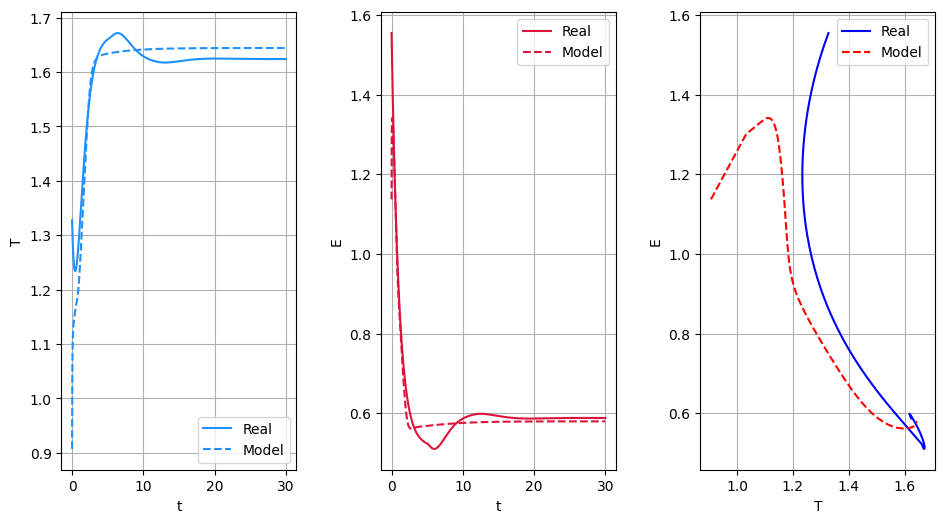

In [80]:
ys, ts, model = main()

In [81]:
class Func(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.mlp = eqx.nn.MLP(
            in_size=data_size,
            out_size=data_size,
            width_size=width_size,
            depth=depth,
            activation=jnn.softplus,
            key=key,
        )

    def __call__(self, t, y, args):
        return self.mlp(y)

class NeuralODE(eqx.Module):
    func: Func

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.func = Func(data_size, width_size, depth, key=key)

    def __call__(self, ts, y0):
        #print(f"y0: {y0}")
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
        )
        return solution.ys

In [82]:
def main2(
    dataset_size=500,
    batch_size=32,
    lr_strategy=(3e-3, 3e-3),
    steps_strategy=(1000, 1000),
    length_strategy=(0.1, 1),
    width_size=16,
    depth=4,
    seed=2,
    plot=True,
    print_every=100,
):
    key = jrandom.PRNGKey(seed)
    model_key, loader_key = jrandom.split(key, 2)
    ys, ts = get_data(dataset_size)
    _, length_size, data_size = ys.shape

    model = NeuralODE(data_size, width_size, depth, key=model_key)


    @eqx.filter_value_and_grad
    def grad_loss(model, ti, yi):
        #print(f"yi: {yi}")
        # yi es de tamaño: [32,10,2]
        # yi[:, 0] es en verdad la condición inicial de tamaño [32, 2]
        y_pred = jax.vmap(model, in_axes=(None, 0))(ti, yi[:, 0, :])
        return jnp.mean((yi - y_pred) ** 2)

    # Es la clausura de la optimización
    # (i.e. lo que ocurre en cada paso)
    @eqx.filter_jit
    def make_step(ti, yi, model, opt_state):
        loss, grads = grad_loss(model, ti, yi)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    # Training loop like normal.
    #
    # Only thing to notice is that up until step 500 we train on only the first 10% of
    # each time series. This is a standard trick to avoid getting caught in a local
    # minimum.

    # Entrenar NeuralODEs es pesado. Es difícil.

    # lr_strategy: (3e-3, 3e-3)
    # steps_strategy: (500, 500)
    # length_strategy: (0.1, 1)

    # Este for loop es en verdad dos fases de entrenamiento:
    # En la primera fase, se entrena por 500 pasos en el 10% del conjunto de datos
    # En la segunda fase, se entrena por 500 pasos en todos los datos.
    for lr, steps, length in zip(lr_strategy, steps_strategy, length_strategy):
        optim = optax.adabelief(lr)
        opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
        _ts = ts[: int(length_size * length)]
        _ys = ys[:, : int(length_size * length)]
        for step, (yi,) in zip(
            range(steps), dataloader((_ys,), batch_size, key=loader_key)
        ):
            start = time.time()
            loss, model, opt_state = make_step(_ts, yi, model, opt_state)
            end = time.time()
            if (step % print_every) == 0 or step == steps - 1:
                print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")

    if plot:

      index = 2
      new_size = int(dataset_size*0.1)
      ys_prueba, ts_prueba = new_get_data(new_size)

      model_y = model(ts_prueba, ys_prueba[index, 0])

      fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,6))
      fig.tight_layout(rect=[0, 0, 1, 0.95], pad=3.0)  # Ajustar diseño de la figura


      # Subgráfico 1
      ax1.plot(ts_prueba, ys_prueba[index, :, 0], c="dodgerblue", label="Real")
      ax1.plot(ts_prueba, model_y[:, 0], c="dodgerblue", label="Model", linestyle="dashed")
      ax1.set_xlabel('t')
      ax1.set_ylabel('T')
      ax1.legend()  # Añadir leyenda al subgráfico 1
      ax1.grid(True)  # Añadir rejilla al subgráfico 1

      # Subgráfico 2
      ax2.plot(ts_prueba, ys_prueba[index, :, 1], c="crimson", label="Real")
      ax2.plot(ts_prueba, model_y[:, 1], c="crimson", label="Model", linestyle="dashed")
      ax2.set_xlabel('t')
      ax2.set_ylabel('E')
      ax2.legend()  # Añadir leyenda al subgráfico 2
      ax2.grid(True)  # Añadir rejilla al subgráfico 2

      # Subgráfico 3
      ax3.plot(ys_prueba[index, :, 0], ys_prueba[index, :, 1], c="blue", label="Real")
      ax3.plot(model_y[:, 0], model_y[:, 1], c="red", label="Model", linestyle="dashed")
      ax3.set_xlabel('T')
      ax3.set_ylabel('E')
      ax3.legend()  # Añadir leyenda al subgráfico 3
      ax3.grid(True)  # Añadir rejilla al subgráfico 3

      # Mostrar la figura
      plt.show()

      errorT=((model_y[:, 0]-ys_prueba[0, :, 0])**2).mean()
      errorE=((model_y[:, 1]-ys_prueba[0, :, 1])**2).mean()
      return ts, ys, model
    else:
      new_size = int(dataset_size*0.3)
      ys_prueba, ts_prueba = new_get_data(new_size)
      model_y = jnp.zeros_like(ys_prueba)
      for i in range(ys_prueba.shape[0]):
        initial_value = ys_prueba[i, 0, :]
        model_y = model_y.at[i].set(model(ts_prueba, initial_value))
      diff_T = ys_prueba[:, :, 0] - model_y[:, :, 0]
      squared_diff_T = diff_T ** 2
      mse_T = jnp.mean(squared_diff_T)
      diff_E = ys_prueba[:, :, 1] - model_y[:, :, 1]
      squared_diff_E = diff_E ** 2
      mse_E = jnp.mean(squared_diff_E)
      error = jnp.mean(jnp.array([mse_E, mse_T]))
      print("El error cuadrático medio (MSE) es: para T", mse_T, ', para E',mse_E,'y general',error, 'depth:', depth, 'width_size:', width_size , 'seed:', seed)
      return ts, ys, model, error, depth, width_size


Generating, compiling, and loading C code.
Using default integration parameters.


/usr/local/lib/python3.10/dist-packages/jitcdde/_jitcdde.py:795: UserWarning: You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.
  warn("You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.")
/usr/local/lib/python3.10/dist-packages/jitcdde/_jitcdde.py:792: UserWarning: The target time is smaller than the current time. 

Step: 0, Loss: 1.382946491241455, Computation time: 22.458536863327026
Step: 100, Loss: 0.13353395462036133, Computation time: 0.01523280143737793
Step: 200, Loss: 0.008599109016358852, Computation time: 0.008714914321899414
Step: 300, Loss: 0.012851810082793236, Computation time: 0.00813436508178711
Step: 400, Loss: 0.009977362118661404, Computation time: 0.013766050338745117
Step: 500, Loss: 0.011335213668644428, Computation time: 0.013954401016235352
Step: 600, Loss: 0.011986419558525085, Computation time: 0.009108781814575195
Step: 700, Loss: 0.004038234706968069, Computation time: 0.009453535079956055
Step: 800, Loss: 0.007829478941857815, Computation time: 0.010162115097045898
Step: 900, Loss: 0.006561648566275835, Computation time: 0.008652687072753906
Step: 999, Loss: 0.003146125003695488, Computation time: 0.01456761360168457
Step: 0, Loss: 0.002433813875541091, Computation time: 12.632252216339111
Step: 100, Loss: 0.0013613360933959484, Computation time: 0.02666759490966797
S

/usr/local/lib/python3.10/dist-packages/jitcdde/_jitcdde.py:795: UserWarning: You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.
  warn("You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.")
/usr/local/lib/python3.10/dist-packages/jitcdde/_jitcdde.py:792: UserWarning: The target time is smaller than the current time. 

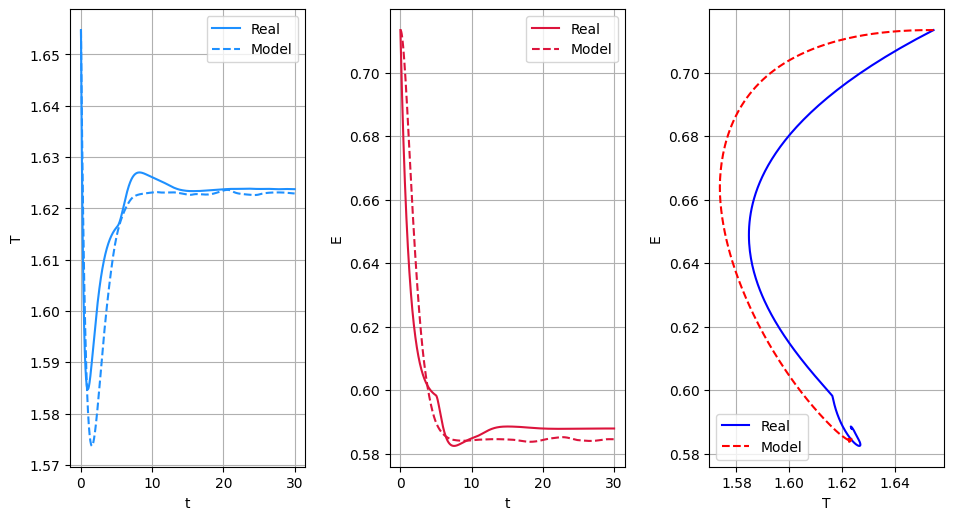

In [83]:
tsn, ysn, modeln = main2()

Generating, compiling, and loading C code.
Using default integration parameters.


/usr/local/lib/python3.10/dist-packages/jitcdde/_jitcdde.py:795: UserWarning: You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.
  warn("You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.")
/usr/local/lib/python3.10/dist-packages/jitcdde/_jitcdde.py:792: UserWarning: The target time is smaller than the current time. 

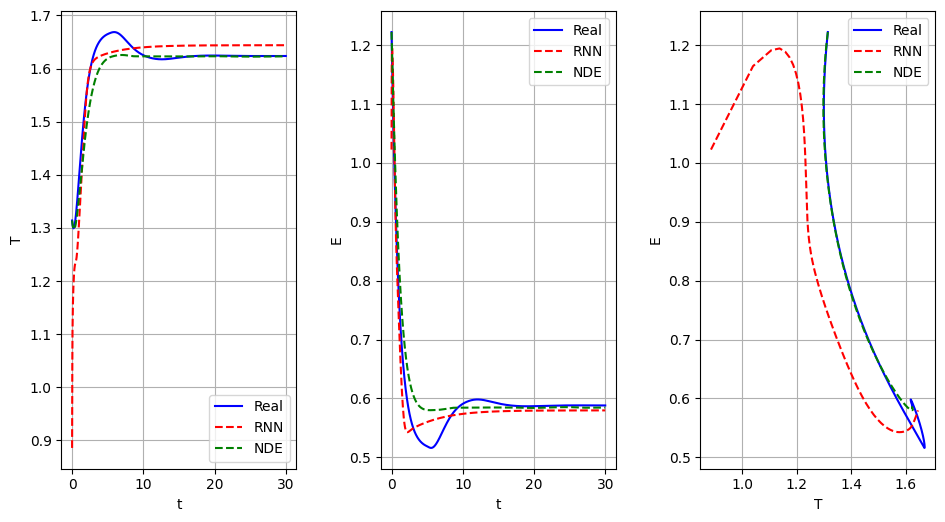

In [86]:
index = 20
new_size = int(256*0.1)
new_seed = 567
new_key = jrandom.PRNGKey(new_seed)

ys_prueba, ts_prueba = new_get_data(new_size)

model_y = model(ys_prueba[index, 0])
model_yn = modeln(ts_prueba, ys_prueba[index, 0])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,6))
fig.tight_layout(rect=[0, 0, 1, 0.95], pad=3.0)  # Ajustar diseño de la figura


# Subgráfico 1
ax1.plot(ts_prueba, ys_prueba[index, :, 0], c="blue", label="Real")
ax1.plot(ts_prueba, model_y[:, 0], c="red", label="RNN", linestyle="dashed")
ax1.plot(ts_prueba, model_yn[:, 0], c="green", label="NDE", linestyle="dashed")
ax1.set_xlabel('t')
ax1.set_ylabel('T')
ax1.legend()  # Añadir leyenda al subgráfico 1
ax1.grid(True)  # Añadir rejilla al subgráfico 1

# Subgráfico 2
ax2.plot(ts_prueba, ys_prueba[index, :, 1], c="blue", label="Real")
ax2.plot(ts_prueba, model_y[:, 1], c="red", label="RNN", linestyle="dashed")
ax2.plot(ts_prueba, model_yn[:, 1], c="green", label="NDE", linestyle="dashed")
ax2.set_xlabel('t')
ax2.set_ylabel('E')
ax2.legend()  # Añadir leyenda al subgráfico 2
ax2.grid(True)  # Añadir rejilla al subgráfico 2

# Subgráfico 3
ax3.plot(ys_prueba[index, :, 0], ys_prueba[index, :, 1], c="blue", label="Real")
ax3.plot(model_y[:, 0], model_y[:, 1], c="red", label="RNN", linestyle="dashed")
ax3.plot(model_yn[:, 0], model_yn[:, 1], c="green", label="NDE", linestyle="dashed")
ax3.set_xlabel('T')
ax3.set_ylabel('E')
ax3.legend()  # Añadir leyenda al subgráfico 3
ax3.grid(True)  # Añadir rejilla al subgráfico 3

# Mostrar la figura
plt.show()

errorT=((model_y[:, 0]-ys_prueba[0, :, 0])**2).mean()
errorE=((model_y[:, 1]-ys_prueba[0, :, 1])**2).mean()

In [ ]:
new_size = 200
new_seed = 567
new_key = jrandom.PRNGKey(new_seed)
ys_prueba, ts_prueba = get_data(new_size)
model_y = jnp.zeros_like(ys_prueba)
model_yn = jnp.zeros_like(ys_prueba)
for i in range(ys_prueba.shape[0]):
  initial_value = ys_prueba[i, 0, :]
  model_y = model_y.at[i].set(model(initial_value))
  model_yn = model_yn.at[i].set(modeln(ts_prueba, initial_value))
diff_T = ys_prueba[:, :, 0] - model_y[:, :, 0]
squared_diff_T = diff_T ** 2
mse_T = jnp.mean(squared_diff_T)
diff_E = ys_prueba[:, :, 1] - model_y[:, :, 1]
squared_diff_E = diff_E ** 2
mse_E = jnp.mean(squared_diff_E)
error = jnp.mean(jnp.array([mse_E, mse_T]))

diff_Tn = ys_prueba[:, :, 0] - model_yn[:, :, 0]
squared_diff_Tn = diff_Tn ** 2
mse_Tn = jnp.mean(squared_diff_Tn)
diff_En = ys_prueba[:, :, 1] - model_yn[:, :, 1]
squared_diff_En = diff_En ** 2
mse_En = jnp.mean(squared_diff_En)
errorn = jnp.mean(jnp.array([mse_En, mse_Tn]))

In [ ]:
print(mse_E, mse_T, error)
print(mse_En, mse_Tn, errorn)